## Environment

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from math import floor
DOWN = 1
UP = 0
LEFT = 2
RIGHT = 3
actions = [UP, DOWN, LEFT, RIGHT]

def row_col_to_seq(row_col, num_cols):  #Converts state number to row_column format
    return row_col[:,0] * num_cols + row_col[:,1]


def seq_to_col_row(seq, num_cols): #Converts row_column format to state number
    r = floor(seq / num_cols)
    c = seq - r * num_cols
    return np.array([[r, c]])
class GridWorld:
    """
    Creates a gridworld object to pass to an RL algorithm.
    Parameters
    ----------
    num_rows : int
        The number of rows in the gridworld.
    num_cols : int
        The number of cols in the gridworld.
    start_state : numpy array of shape (1, 2), np.array([[row, col]])
        The start state of the gridworld (can only be one start state)
    goal_states : numpy arrany of shape (n, 2)
        The goal states for the gridworld where n is the number of goal
        states.
    """
    def __init__(self, num_rows, num_cols, start_state, goal_states, wind = False):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.start_state = start_state
        self.goal_states = goal_states
        self.obs_states = None
        self.bad_states = None
        self.num_bad_states = 0
        self.p_good_trans = None
        self.bias = None
        self.r_step = None
        self.r_goal = None
        self.r_dead = None
        self.gamma = 1 # default is no discounting
        self.wind = wind
        # M
        self.steps = 0
        self.done = False
        self.grid = np.zeros((10,10), int)
    
    # this function helps in creating a grid world and printing the grid world
    def create_grid(self):
        for state in self.start_state:         # start state
          self.grid[state[0]][state[1]] = 1

        for state in self.goal_states:         # goal state
          self.grid[state[0]][state[1]] = 2

        for state in self.obs_states:
          self.grid[state[0]][state[1]] = 3    # obstacles state

        for state in self.bad_states:
          self.grid[state[0]][state[1]] = 4    # bad state

        for state in self.restart_states:
          self.grid[state[0]][state[1]] = 5    # restart state

    '''
    render: render a plot of the environment
    '''
    def render(self, ax = None):
        grid = self.grid.copy()
        
        plt.clf()
        
        cmap = colors.ListedColormap(['#F5E5E1', '#F2A494', '#00FF23', '#0004FF', '#FF2D00', '#F0FF00'])
        if ax is None:
            fig, ax = plt.subplots()
        
        ax.pcolor(grid, cmap=cmap, edgecolors='k', linewidths=2)


    def add_obstructions(self, obstructed_states=None, bad_states=None, restart_states=None):

        self.obs_states = obstructed_states
        self.bad_states = bad_states
        if bad_states is not None:
            self.num_bad_states = bad_states.shape[0]
        else:
            self.num_bad_states = 0
        self.restart_states = restart_states
        if restart_states is not None:
            self.num_restart_states = restart_states.shape[0]
        else:
            self.num_restart_states = 0

    def add_transition_probability(self, p_good_transition, bias):

        self.p_good_trans = p_good_transition
        self.bias = bias

    def add_rewards(self, step_reward, goal_reward, bad_state_reward=None, restart_state_reward = None):

        self.r_step = step_reward
        self.r_goal = goal_reward
        self.r_bad = bad_state_reward
        self.r_restart = restart_state_reward


    def create_gridworld(self):

        self.num_actions = 4
        self.num_states = self.num_cols * self.num_rows# +1
        self.start_state_seq = row_col_to_seq(self.start_state, self.num_cols)
        self.goal_states_seq = row_col_to_seq(self.goal_states, self.num_cols)

        # rewards structure
        self.R = self.r_step * np.ones((self.num_states, 1))
        #self.R[self.num_states-1] = 0
        self.R[self.goal_states_seq] = self.r_goal
        
        for i in range(self.num_bad_states):
            if self.r_bad is None:
                raise Exception("Bad state specified but no reward is given")
            bad_state = row_col_to_seq(self.bad_states[i,:].reshape(1,-1), self.num_cols)
            #print("bad states", bad_state)
            self.R[bad_state, :] = self.r_bad
        for i in range(self.num_restart_states):
            if self.r_restart is None:
                raise Exception("Restart state specified but no reward is given")
            restart_state = row_col_to_seq(self.restart_states[i,:].reshape(1,-1), self.num_cols)
            #print("restart_state", restart_state)
            self.R[restart_state, :] = self.r_restart

        # probability model
        if self.p_good_trans == None:
            raise Exception("Must assign probability and bias terms via the add_transition_probability method.")

        self.P = np.zeros((self.num_states,self.num_states,self.num_actions))
        for action in range(self.num_actions):
            for state in range(self.num_states):


                # check if the state is the goal state or an obstructed state - transition to end
                row_col = seq_to_col_row(state, self.num_cols)
                if self.obs_states is not None:
                    end_states = np.vstack((self.obs_states, self.goal_states))
                else:
                    end_states = self.goal_states

                if any(np.sum(np.abs(end_states-row_col), 1) == 0):
                    self.P[state, state, action] = 1

                # else consider stochastic effects of action
                else:
                    for dir in range(-1,2,1):
                        
                        direction = self._get_direction(action, dir)
                        next_state = self._get_state(state, direction)
                        if dir == 0:
                            prob = self.p_good_trans
                        elif dir == -1:
                            prob = (1 - self.p_good_trans)*(self.bias)
                        elif dir == 1:
                            prob = (1 - self.p_good_trans)*(1-self.bias)

                        self.P[state, next_state, action] += prob

                # make restart states transition back to the start state with
                # probability 1
                if self.restart_states is not None:
                    if any(np.sum(np.abs(self.restart_states-row_col),1)==0):
                        next_state = row_col_to_seq(self.start_state, self.num_cols)
                        self.P[state,:,:] = 0
                        self.P[state,next_state,:] = 1
        return self

    def _get_direction(self, action, direction):

        left = [2,3,1,0]
        right = [3,2,0,1]
        if direction == 0:
            new_direction = action
        elif direction == -1:
            new_direction = left[action]
        elif direction == 1:
            new_direction = right[action]
        else:
            raise Exception("getDir received an unspecified case")
        return new_direction

    def _get_state(self, state, direction):

        row_change = [-1,1,0,0]
        col_change = [0,0,-1,1]
        row_col = seq_to_col_row(state, self.num_cols)
        row_col[0,0] += row_change[direction]
        row_col[0,1] += col_change[direction]

        # check for invalid states
        if self.obs_states is not None:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1) or
                np.any(np.sum(abs(self.obs_states - row_col), 1)==0)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]
        else:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]

        return next_state

    def reset(self):
      self.done = False
      self.steps = 0
      return int(self.start_state_seq)
      
    def step(self, state, action):
        # M
        self.steps += 1
        p, r = 0, np.random.random()
        for next_state in range(self.num_states):
            
            p += self.P[state, next_state, action]
            
            if r <= p:
                break

        if(self.wind and np.random.random() < 0.4):

          arr = self.P[next_state, :, 3]
          next_next = np.where(arr == np.amax(arr))
          next_next = next_next[0][0]
          if(next_next in self.goal_states_seq or self.steps == 100):
            self.done = True
          return next_next, self.R[next_next], self.done
        else:
          if(next_state in self.goal_states_seq or self.steps == 100):
            self.done = True
          return next_state, self.R[next_state], self.done


## Environment Initialization

In [ ]:
# specify world parameters
num_cols = 10
num_rows = 10
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
restart_states = np.array([[3,7],[8,2]])
start_state = np.array([[0, 4]])
goal_states = np.array([[0,9],[2,2],[8,7]])

# create model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False)
gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)
gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=1.0,
                              bias=0.5)
gw.create_grid()
env = gw.create_gridworld()


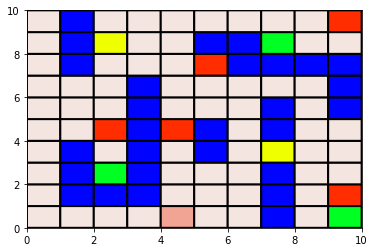

In [ ]:
env.render(ax = plt)

Legend

Pink is the start

Blue is the Obstruction state

Red is the BAD state.

Yellow is the restart state

Green is the Goal state

## Plotting

### Q Plot

In [ ]:
def plot_Q(Q, message="Q plot", save=False, experiment_number=0, experiment_name="Sarsa"):
    
    plt.figure(figsize=(10,10))
    plt.title(message)
    plt.pcolor(Q.max(-1), edgecolors='k', linewidths=2)
    plt.colorbar()
    def x_direct(a):
        if a in [UP, DOWN]:
            return 0
        return 1 if a == RIGHT else -1
    def y_direct(a):
        if a in [RIGHT, LEFT]:
            return 0
        return 1 if a == DOWN else -1
    policy = Q.argmax(-1)
    policyx = np.vectorize(x_direct)(policy)
    policyy = np.vectorize(y_direct)(policy)
    idx = np.indices(policy.shape)
    plt.quiver(idx[1].ravel()+0.5, idx[0].ravel()+0.5, policyx.ravel(), policyy.ravel(), pivot="middle", color='red')
    if(save):
            plt.savefig(f"{experiment_name}{experiment_number}_heatmap.png")
    plt.show()

### Visits HeatMap

In [ ]:
def plot_heatmap(data, experiment_number = 0, experiment_name = "SARSA"):
        # # Function to show the heat map
        # plt.imshow( data , cmap = 'heatmap' )
        
        # # Adding details to the plot
        # plt.title( "Number of visits" )
        # plt.xlabel('x-axis')
        # plt.ylabel('y-axis')

        # # Adding a color bar to the plot
        # plt.colorbar()

        # # Displaying the plot
        # plt.show()
        plt.title("Number Of Visits")
        plt.imshow(np.flipud(data), cmap = 'hot', interpolation='nearest')
        plt.colorbar()
        plt.savefig(f"{experiment_name}{experiment_number}_visits_heatmap.png")
        plt.show()

## Initial Q Plot

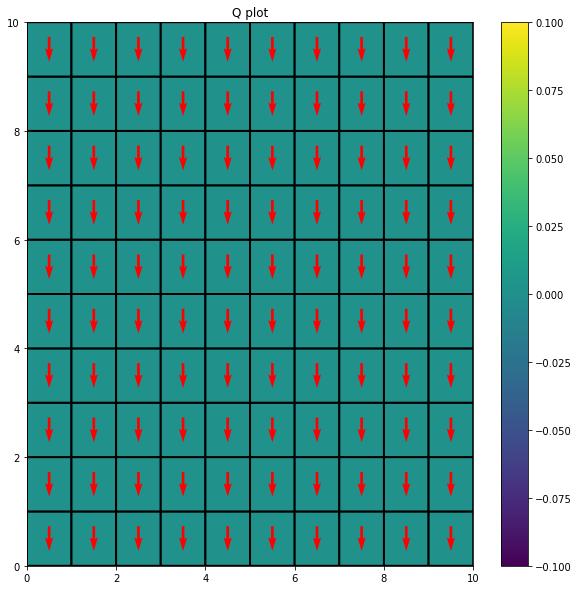

In [ ]:
Q = np.zeros((10, 10, 4))

plot_Q(Q)

## Policies

In [ ]:
import random
from scipy.special import softmax

seed = 42
rg = np.random.RandomState(seed)

# Epsilon greedy
def choose_action_epsilon(Q, state, epsilon, rg=rg):
    if (not Q[state[0], state[1]].any()) or random.random() <= epsilon: # TODO: eps greedy condition
        return random.choice(actions) # TODO: return random action
    else:
        return max(actions, key = lambda action : Q[state[0]][state[1]][action])# TODO: return best action

# Softmax
def choose_action_softmax(Q, state, tau, rg=rg):
    action_value = Q[state[0]][state[1]]
    max_value = action_value.max()
    exp_values = [np.exp((v-max_value) / tau) for v in action_value]
    normalizer = np.sum(exp_values)
    prob = [v/normalizer for v in exp_values]
    action = np.random.choice(actions, p=prob)
    return action # TODO: return random action with selection probability

## Imports and necessary functions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
%matplotlib inline

In [ ]:
def seq_to_col_row_(seq, num_cols): #Converts row_column format to state number
    r = floor(seq / num_cols)
    c = seq - r * num_cols
    return (r, c)

In [ ]:
Q = np.zeros((10, 10, 4))# initialize Q-value

episodes = 10000


## SARSA

In [ ]:
print_freq = 100

def sarsa(env, Q, plot_heat = False, choose_action = 0, epsilon = 0.1, tau = 1, alpha = 0.4, gamma = 0.9, experiment_number = 0):
    Q = np.zeros((10, 10, 4))# initialize Q-value

    visits = np.zeros((10, 10))


    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    if plot_heat:
        clear_output(wait=True)
        plot_Q(Q)
    for ep in tqdm(range(episodes)):
        tot_reward, steps = 0, 0
        
        # Reset environment
        state = env.reset()
        state_ = seq_to_col_row_(state, 10) # to convert seq no. of state to row col
        visits[state_[0]][state_[1]] += 1
        if choose_action == 0:
          action = choose_action_epsilon(Q, state_, epsilon)
        else:
          action = choose_action_softmax(Q, state_, tau)
        done = False
        while not done:
            state_ = seq_to_col_row_(state, 10)
            state_next, reward, done = env.step(state, action)
            state_next_ = seq_to_col_row_(state_next, 10) # to convert seq no. of state to row col

            if choose_action == 0:
              action_next = choose_action_epsilon(Q, state_next_, epsilon)
            else:
              action_next = choose_action_softmax(Q, state_next_, tau)
            visits[state_next_[0]][state_next_[1]] += 1
            # TODO: update equation
            Q[state_[0]][state_[1]][action] = Q[state_[0]][state_[1]][action] + alpha *(reward + max(Q[state_next_[0]][state_next_[1]]) - Q[state_[0]][state_[1]][action])
                                                    
            tot_reward += reward
            steps += 1
            
            state, action = state_next, action_next
        
        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps
        
        if (ep+1)%print_freq == 0 and plot_heat:
            clear_output(wait=True)
            message = f"SARSA ( Experiment: {experiment_number} )\n"
            message += f" Wind: {env.wind}\n"
            message += "Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f"%(ep+1, np.mean(episode_rewards[ep-print_freq+1:ep]),
                                                                           np.mean(steps_to_completion[ep-print_freq+1:ep]),
                                                                           Q.max(), Q.min())
            if (ep + 1) != episodes:
               plot_Q(Q,message)
            else:
               plot_Q(Q, message, True, experiment_number, "SARSA ")
               plot_heatmap(visits, "SARSA ")
                
    return Q, episode_rewards, steps_to_completion

In [ ]:
# Q, rewards, steps = sarsa(env, Q, plot_heat=True, choose_action= 0, epsilon= 0.1,tau = 0.81, alpha=0.4 , gamma=.99) # choose action 0 for e greedy and 1 for softmax

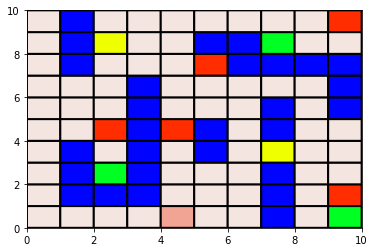

In [ ]:
env.render(ax = plt)


### Analyzing performance of the policy
We use two metrics to analyze the policies:

1. Average steps to reach the goal
2. Total rewards from the episode

To ensure, we account for randomness in environment and algorithm (say when using epsilon-greedy exploration), we run the algorithm for multiple times and use the average of values over all runs.

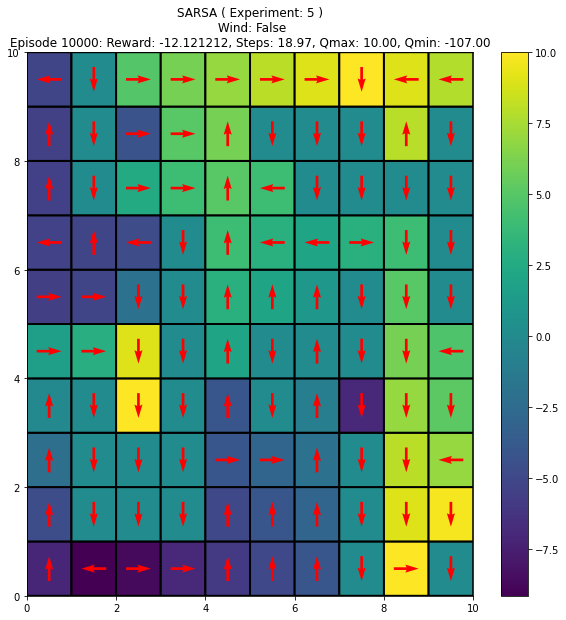

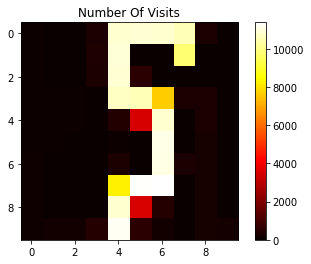

100%|██████████| 10000/10000 [00:51<00:00, 194.53it/s]


In [ ]:
num_expts = 5
reward_avgs, steps_avgs = np.zeros(10000), np.zeros(10000)

for i in range(num_expts):
    print("Experiment: %d"%(i+1))
    Q = np.zeros((10, 10, 4))
    rg = np.random.RandomState(i)

    # TODO: run sarsa, store metrics
    Q, rewards, steps = sarsa(env, Q, plot_heat=True, choose_action= 0, epsilon= 0.1,tau = 0.5, alpha=0.4 , gamma=0.99, experiment_number= i + 1)
    reward_avgs = reward_avgs + rewards
    steps_avgs = steps_avgs + steps

reward_avgs = reward_avgs/num_expts
steps_avgs = steps_avgs/num_expts

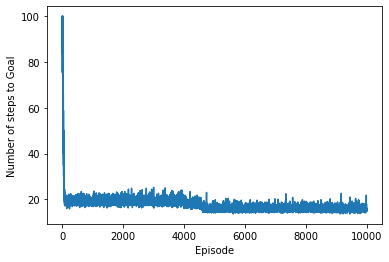

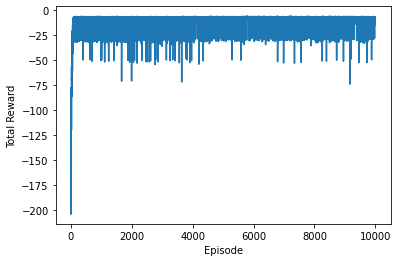

In [ ]:
# TODO: visualize individual metrics vs episode count (averaged across multiple run(s))
x = np.arange(0, 10000)
plt.figure()
plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
plt.plot(x, steps_avgs)
plt.savefig("SARSA_NSteps.png")
plt.show()

plt.figure()
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(x, reward_avgs)
plt.savefig("SARSA_avg_rewards.png")
plt.show()

## QLearning


In [ ]:
print_freq = 100

def sarsa(env, Q, plot_heat = False, choose_action = 0, epsilon = 0.1, tau = 1, alpha = 0.4, gamma = 0.9, experiment_number = 0):
    Q = np.zeros((10, 10, 4))# initialize Q-value

    visits = np.zeros((10, 10))


    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    if plot_heat:
        clear_output(wait=True)
        plot_Q(Q)
    for ep in tqdm(range(episodes)):
        tot_reward, steps = 0, 0
        
        # Reset environment
        state = env.reset()
        state_ = seq_to_col_row_(state, 10) # to convert seq no. of state to row col
        visits[state_[0]][state_[1]] += 1
        if choose_action == 0:
          action = choose_action_epsilon(Q, state_, epsilon)
        else:
          action = choose_action_softmax(Q, state_, tau)
        done = False
        while not done:
            state_ = seq_to_col_row_(state, 10)
            state_next, reward, done = env.step(state, action)
            state_next_ = seq_to_col_row_(state_next, 10) # to convert seq no. of state to row col

            if choose_action == 0:
              action_next = choose_action_epsilon(Q, state_next_, epsilon)
            else:
              action_next = choose_action_softmax(Q, state_next_, tau)
            visits[state_next_[0]][state_next_[1]] += 1
            # TODO: update equation
            Q[state_[0]][state_[1]][action] = Q[state_[0]][state_[1]][action] + alpha *(reward + gamma * max(Q[state_next_[0]][state_next_[1]]) - Q[state_[0]][state_[1]][action])
                                                    
            tot_reward += reward
            steps += 1
            
            state, action = state_next, action_next
        
        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps
        
        if (ep+1)%print_freq == 0 and plot_heat:
            clear_output(wait=True)
            message = f"SARSA ( Experiment: {experiment_number} )\n"
            message += f" Wind: {env.wind}\n"
            message += "Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f"%(ep+1, np.mean(episode_rewards[ep-print_freq+1:ep]),
                                                                           np.mean(steps_to_completion[ep-print_freq+1:ep]),
                                                                           Q.max(), Q.min())
            if (ep + 1) != episodes:
               plot_Q(Q,message)
            else:
               plot_Q(Q, message, True, experiment_number, "SARSA ")
               plot_heatmap(visits, "SARSA ")
                
    return Q, episode_rewards, steps_to_completion

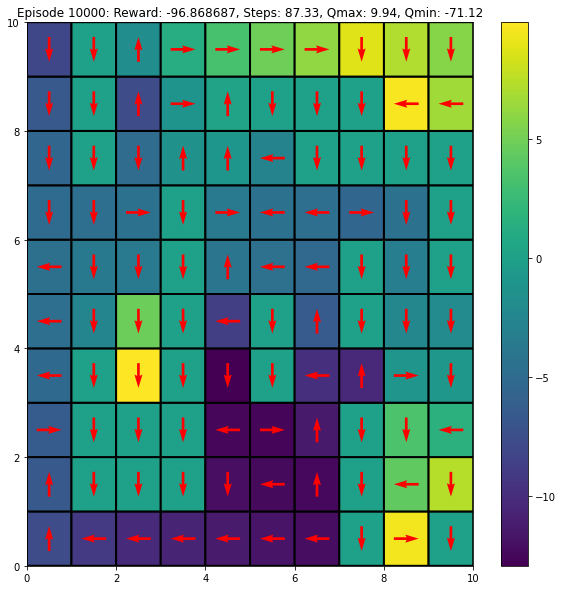

100%|██████████| 10000/10000 [02:27<00:00, 67.77it/s]


In [ ]:
Q, rewards, steps = Qlearning(env, Q, plot_heat=True, choose_action= 1, epsilon=0.1, tau = 5, alpha=.4, gamma= 0.95) # choose action 0 for e greedy and 1 for softmax